In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

import time

# Бенчмарк

In [2]:
def benchmark(f, n: int or float = 10e5, args: tuple = None, kwargs: dict = None) -> np.array:
    if args is None:
        args = ()
    if kwargs is None:
        kwargs = {}
    
    start = time.process_time()
    for _ in range(int(n)):
        f(*args, **kwargs)
    end = time.process_time()
    return (end - start)/n

# Матрица блоками

In [29]:
def Laplace(N = 3,M = 4):
    L = np.zeros((N,M,N,M), dtype=int)
#     a, b, c, d, e = 'a', 'b', 'c', 'd', 'e'
    a, b, c, d, e = 1, 1, 1, 1, -4
    
    indNdiag = np.arange(N)
    indNup = np.roll(indNdiag, 1)
    indNdown = np.roll(indNdiag, -1)
    
    indMdiag = np.arange(M)
    indMup = np.roll(indMdiag, 1)
    indMdown = np.roll(indMdiag, -1)
    
    for n in range(N):
        L[n,indMdiag,indNdiag[n],indMdiag] = e
        L[n,indMup,indNdiag[n],indMdiag] = c
        L[n,indMdown,indNdiag[n],indMdiag] = d

        L[n,indMdiag,indNup[n],indMdiag] = b

        L[n,indMdiag,indNdown[n],indMdiag] = a

    return L.reshape(N*M, N*M)


Л = Laplace(4,4)
# plt.imshow(Л, cmap='jet', vmin=-4, vmax=5)
# plt.colorbar()
Л

array([[-4,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 1, -4,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1, -4,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 1,  0,  1, -4,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0, -4,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  1, -4,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1, -4,  1,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  1, -4,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0, -4,  1,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  1, -4,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  1, -4,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1, -4,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -4,  1,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,

# Матрица формулой

$$(\Delta)_{kj} = \frac{au_{k-1,j}+bu_{k+1,j}+eu_{k,j}+cu_{k,j+1}+du_{k,j-1}}{\delta^2}$$

In [30]:
def laplas_simple(u, L, h=1):
    K, J = u.shape
    for k in range(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2

u = np.eye(9)
L = np.zeros_like(u)
laplas(u, L)
L

N, M = 1000,1000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for', benchmark(laplas_simple, n=1, args=(u, L, 1))* 100)

for 203.125


In [31]:
@nb.njit(parallel=True)
def laplas(u, L, h=1):
    K, J = u.shape
    for k in nb.prange(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2

u = np.eye(9)
L = np.zeros_like(u)
laplas(u, L)
L

N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit parallel', benchmark(laplas, n=5, args=(u, L, 1)))

for + jit parallel 1.66875


In [32]:
def laplas_2(u, L, h=1):
    K, J = u.shape
    ind_K = np.arange(K)
    ind_J = np.arange(J)
    
    L[:,:] = (u[(ind_K+1) % K,:] + u[(ind_K-1) % K,:] -4*u[:,:] + u[:,(ind_J-1) % J] + u[:,(ind_J+1) % J])/h**2
    

N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('ind ', benchmark(laplas_2, n=1, kwargs={'u': u, 'L':L}))

ind  7.34375


In [33]:
def laplas_3(u, L, h=1):
    K, J = u.shape
    ind_K = np.arange(K)
    ind_J = np.arange(J)
    
    L[:,:] = (u.take((ind_K+1) % K, axis=0) + u.take((ind_K-1) % K, axis=0) -4* u[:,:] + u.take((ind_J-1) % J, axis=1) + u.take((ind_J+1) % J, axis=1))/h**2
    

N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('take ', benchmark(laplas_3, n=5, kwargs={'u': u, 'L':L})*10e6)

take  34687500.0


In [34]:
@nb.njit('void(f8[:,::1],f8[:,::1],f8)' )
def laplas_no_bc(u, L, h):
    K, J = u.shape
    i = 1/h**2
    for k in nb.prange(1, K-1):
        for j in range(1, J-1):
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)]) * i
        
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_no_bc, n=5, args=(u, L, 1)))

for + jit  0.30625


In [35]:
@nb.njit('void(f8[:,::1],f8[:,::1],f8)')
def laplas_4(u, L, h):
    K, J = u.shape
    for k in nb.prange(1,K-1):
        for j in range(1,J-1):
#             L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)])
    
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit void([])', benchmark(laplas_4, n=5, args=(u, L, 1)))

for + jit void([]) 0.26875


In [36]:
nb.set_num_threads(1)

@nb.njit('void(f8[:,::1],f8[:,::1],f8)', nogil=True, parallel=True)
def laplas_7(u, L, h):
    K, J = u.shape
    for k in nb.prange(1,K-1):
        for j in range(1,J-1):
#             L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)])
        L[k,0] = (u[(k+1),0]+u[(k-1),0]-4*u[k,0]+u[k,1]+u[k,J-1])
        L[k,J-1] = (u[(k+1),J-1]+u[(k-1),J-1]-4*u[k,J-1]+u[k,0]+u[k,J-2])
        
    for j in range(1,J-1):
        L[0,j] = (u[1,j]+u[K-1,j]-4*u[0,j]+u[0,(j+1)]+u[0,(j-1)])
    L[0,0] = (u[1,0]+u[K-1,0]-4*u[0,0]+u[0,1]+u[0,J-1])
    L[0,J-1] = (u[1,J-1]+u[(K-1),J-1]-4*u[0,J-1]+u[0,0]+u[0,J-2])
    
    for j in range(1,J-1):
        L[K-1,j] = (u[0,j]+u[K-2,j]-4*u[K-1,j]+u[K-1,(j+1)]+u[K-1,(j-1)])
    L[K-1,0] = (u[0,0]+u[K-2,0]-4*u[K-1,0]+u[K-1,1]+u[K-1,J-1])
    L[K-1,J-1] = (u[0,J-1]+u[K-2,J-1]-4*u[K-1,J-1]+u[K-1,0]+u[K-1,J-2])
    
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('best, hard-way', benchmark(laplas_7, n=5, args=(u, L, 1)))

best, hard-way 0.28125


In [37]:
@nb.njit('void(f8[:,:],f8[:,:],f8)', parallel=True)
def laplas_6(u, L, h):
    K, J = u.shape
    for k in nb.prange(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit parallel ', benchmark(laplas_6, n=5, args=(u, L, 1)))

for + jit parallel  1.4625


In [38]:
@nb.njit('void(f8[:,:],f8[:,:],f8)', nogil=True, )
def laplas_7(u, L, h):
    K, J = u.shape
    for k in nb.prange(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit nogil ', benchmark(laplas_7, n=5, args=(u, L, 1)))

for + jit nogil  0.83125


# Применение

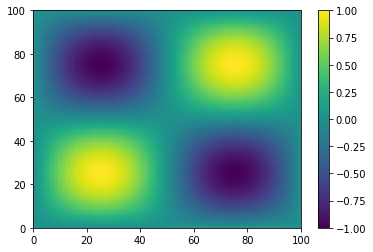

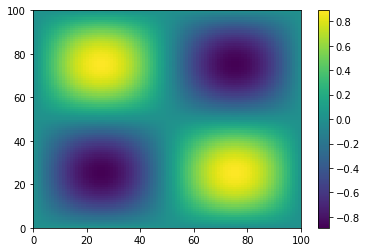

In [9]:
x, y = np.meshgrid(np.linspace(0, 2*np.pi, 100, endpoint=False), np.linspace(0, 2*np.pi, 100, endpoint=False))
u = np.sin(x)*np.sin(y)
plt.pcolor(u)
plt.colorbar()
plt.figure()


L = np.zeros_like(u)
laplas_7(u, L, h = 3*np.pi/100)
plt.pcolor(L)
plt.colorbar()

In [197]:
a = np.arange(16)
a = a.reshape(4,4)
print(a)
a[np.arange(4),:]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])